<a href="https://colab.research.google.com/github/marvin-hansen/fastai/blob/master/Lesson_7_0_SuperRes_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 7: Resnets from scratch; U-net;  & GAN

https://course.fast.ai/videos/?lesson=7

https://github.com/hiromis/notes/blob/master/Lesson7.md



In the final lesson of Practical Deep Learning for Coders we'll study one of the most important techniques in modern architectures: the skip connection. This is most famously used in the resnet, which is the architecture we've used throughout this course for image classification, and appears in many cutting edge results. We'll also look at the U-net architecture, which uses a different type of skip connection to greatly improve segmentation results (and also for similar tasks where the output structure is similar to the input).

We'll then use the U-net architecture to train a super-resolution model. This is a model which can increase the resolution of a low-quality image. Our model won't only increase resolution—it will also remove jpeg artifacts, and remove unwanted text watermarks.

In order to make our model produce high quality results, we will need to create a custom loss function which incorporates feature loss (also known as perceptual loss), along with gram loss. These techniques can be used for many other types of image generation task, such as image colorization.

Finally, we'll learn about a recent loss function known as generative adversarial loss (used in generative adversarial networks, or GANs), which can improve the quality of generative models in some contexts, at the cost of speed.

The techniques we show in this lesson include some unpublished research that:

* Let us train GANs more quickly and reliably than standard approaches, by leveraging transfer learning
* Combines architectural innovations and loss function approaches that haven't been used in this way before.

The results are stunning, and train in just a couple of hours (compared to previous approaches that take a couple of days).

# Notes


## Install 

In [0]:
!pip install imgaug==0.2.7

!pip install folium==0.2.1

!pip install --upgrade pandas

!pip install --upgrade numpy

!pip install isoweek

#!pip install --upgrade fastai

# install "crappify"
! wget https://raw.githubusercontent.com/fastai/course-v3/master/nbs/dl1/crappify.py

!curl -s https://course.fast.ai/setup/colab | bash

## Constants & global flags

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#batch size 

#bs = 64
 bs = 32 
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Import Fast.ai & PyTorch


In [3]:
import fastai
from fastai import *
from fastai.basics import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn


from fastai.metrics import error_rate
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Requires script download, see install section 
from crappify import *


print("FastAI Version: " + str(fastai.__version__))

FastAI Version: 1.0.51


In [4]:
import torch

print("PyTorch Version: " + str(torch.__version__))

PyTorch Version: 1.0.1.post2


## CUDA GPU 

In [0]:
def check_cuda_mem():
      print()
      print("GPU used: " + torch.cuda.get_device_name(0))
      print('Memory Usage:')
      print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
      print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

In [0]:
def check_cuda():
  torch.cuda.current_device()
  print("Cuda available: " + str(torch.cuda.is_available()))
  print("Cuda enabled:" + str(torch.backends.cudnn.enabled))
  #https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
  # setting device on GPU if available, else CPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Using device:', device)
  print()
  #Additional Info when using cuda
  if device.type == 'cuda':
     check_cuda_mem()

In [11]:
check_cuda()

Cuda available: True
Cuda enabled:True
Using device: cuda


GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# GPU Memory management 

In [0]:
def set_bs():
  free = gpu_mem_get_free_no_cache()
  # the max size of the test image depends on the available GPU RAM 
  if free > 10000: bs=32
  if free > 8200: bs=16
  else:           bs=8
  print(f"using bs={bs}, size={size}, have {free}MB of GPU RAM free")
  return bs

In [0]:
def clear_memory(learn=None):
  # Clear Cuda cache, if running OOM
    print()
    print("MemMan: Clearing memory ") 
    if learn is not None: # if a learner is given as parameter, destroy it first     
       learn.destroy() 
       learn = None # object needs to be un-referened to get removed during GC
    
    gc.collect() # call gc 
    torch.cuda.empty_cache() # free cache after GC 
    print("MemMan: Done!") 

    check_cuda_mem()

In [13]:
check_cuda_mem()
clear_memory()


GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB

MemMan: Clearing memory 
MemMan: Done!

GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [0]:
def set_bs():
  free = gpu_mem_get_free_no_cache()
  # the max size of the test image depends on the available GPU RAM 
  if free > 8200: bs,size=16,256  
  else:           bs,size=8,256
  print(f"using bs={bs}, size={size}, have {free}MB of GPU RAM free")
  return bs

# Super resolution¶


In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [0]:
il = ImageList.from_folder(path_hr)


In [0]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [0]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [0]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

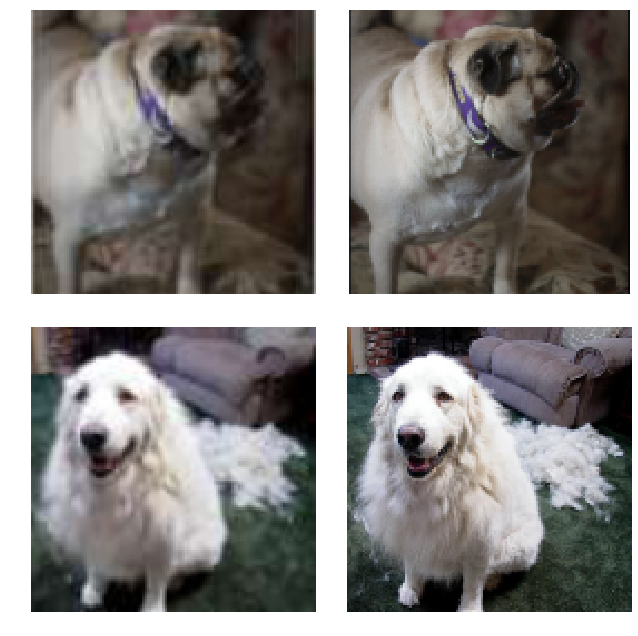

In [20]:
data = get_data(bs,size)
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

# Feature loss¶


In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [23]:
gram_matrix(t)


tensor([[[0.0636, 0.0605, 0.0578],
         [0.0605, 0.0579, 0.0554],
         [0.0578, 0.0554, 0.0534]],

        [[0.0636, 0.0605, 0.0578],
         [0.0605, 0.0579, 0.0554],
         [0.0578, 0.0554, 0.0534]]])

In [0]:
base_loss = F.l1_loss


In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [26]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])
base_loss = F.l1_loss


# Train

In [29]:
# Free memory
check_cuda_mem()
clear_memory()


GPU used: Tesla K80
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB

MemMan: Clearing memory 
MemMan: Done!

GPU used: Tesla K80
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB


In [30]:
# set batch size according to free memory 
bs= set_bs()

using bs=16, size=256, have 11064MB of GPU RAM free


In [0]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)

In [0]:
def get_unet_Learner():
    return unet_learner(data, arch, wd=1e-3, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


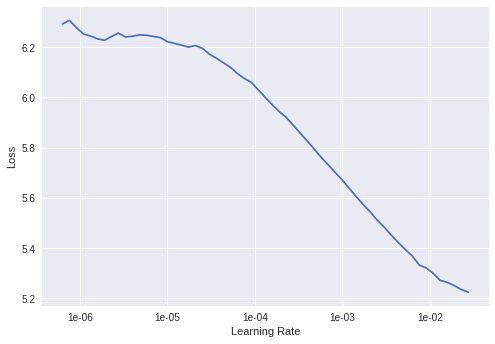

In [33]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
def do_fit(learn, save_name, epochs=10, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save(save_name, , return_path=True)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.887757,3.725564,0.142408,0.230476,0.316165,0.224582,0.557759,1.207855,1.046318,04:36
1,3.734495,3.563176,0.143505,0.226260,0.305636,0.214869,0.518086,1.152275,1.002544,04:31
2,3.650582,3.486303,0.143036,0.225772,0.301565,0.207921,0.507905,1.132940,0.967163,04:30
3,3.632746,3.434207,0.145080,0.223103,0.296783,0.204173,0.495947,1.115900,0.953220,04:29
4,3.577229,3.414528,0.143292,0.222742,0.294521,0.203097,0.497923,1.105040,0.947913,04:29
5,3.515285,3.310521,0.140811,0.221160,0.289171,0.198333,0.466541,1.065766,0.928740,04:29
6,3.489531,3.310342,0.140362,0.220672,0.288488,0.196765,0.476848,1.068766,0.918441,04:28
7,3.469461,3.247108,0.141794,0.218424,0.284486,0.194268,0.450053,1.048315,0.909768,04:28
8,3.436904,3.251873,0.139542,0.217987,0.284061,0.194389,0.456292,1.047333,0.912268,04:28
9,3.369412,3.133826,0.135358,0.214759,0.276823,0.187293,0.428528,1.013534,0.877531,04:27


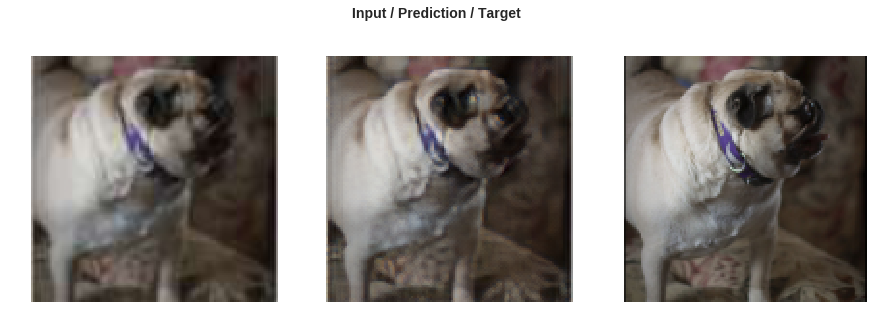

In [41]:
do_fit(learn, '1a', epochs=10, slice(lr*10))


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.324629,3.127368,0.135187,0.214540,0.276375,0.186848,0.427616,1.011729,0.875074,04:37
1,3.323298,3.122748,0.134886,0.214315,0.276079,0.186515,0.427082,1.010358,0.873513,04:37
2,3.295490,3.117175,0.134807,0.214056,0.275699,0.186017,0.426231,1.009075,0.871289,04:37
3,3.324122,3.113846,0.135206,0.214482,0.275738,0.185885,0.423724,1.008222,0.870589,04:37
4,3.305037,3.110890,0.134703,0.213672,0.274945,0.185749,0.424923,1.006740,0.870158,04:37
5,3.310245,3.107677,0.134583,0.213477,0.274795,0.185679,0.424264,1.005533,0.869345,04:37
6,3.281079,3.104246,0.135020,0.213271,0.274417,0.185461,0.422036,1.003769,0.870273,04:36
7,3.282372,3.092607,0.134937,0.212927,0.273808,0.184758,0.419297,1.000194,0.866686,04:37
8,3.260470,3.097418,0.134891,0.212978,0.273621,0.185369,0.419362,1.001316,0.869882,04:37
9,3.264765,3.071562,0.134844,0.212420,0.272508,0.183531,0.413593,0.994508,0.860158,04:36


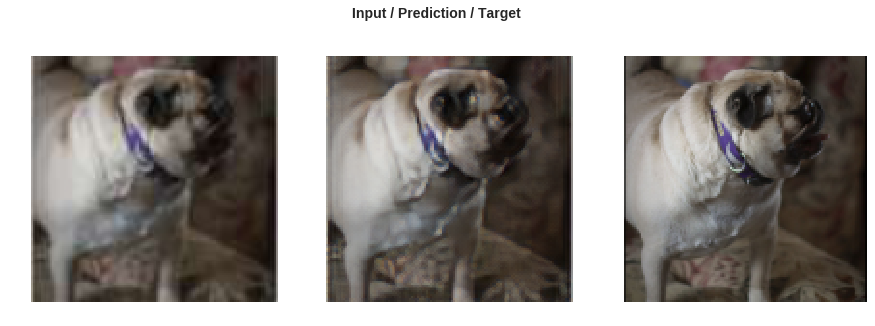

In [43]:
learn.unfreeze()
do_fit(learn, '1b', slice(1e-5,lr))


In [44]:
check_cuda_mem()
clear_memory()


GPU used: Tesla K80
Memory Usage:
Allocated: 0.9 GB
Cached:    6.3 GB

MemMan: Clearing memory 
MemMan: Done!

GPU used: Tesla K80
Memory Usage:
Allocated: 0.9 GB
Cached:    6.3 GB


In [0]:
data = get_data(12,size*2)
learn.data = data
learn.freeze()

In [0]:
learn.load('1b');


In [0]:
# set batch size according to free memory 
bs= 8 #set_bs()

In [0]:
do_fit(learn, '2a')


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.232717,2.192852,0.161817,0.258271,0.293782,0.155969,0.378204,0.577785,0.367024,16:46
1,2.202825,2.171100,0.162466,0.258981,0.293370,0.155157,0.365865,0.571931,0.363330,16:40


In [0]:
learn.save("2a", return_path=True)

In [0]:
check_cuda_mem()
clear_memory()

In [0]:
learn.unfreeze()
do_fit(learn,'2b', slice(1e-6,1e-4), pct_start=0.3)

# Test


In [0]:
# Free memory
clear_memory(learn)

In [0]:
bs = set_bs()

In [0]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)


In [0]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [0]:
learn.load('2b');


In [0]:
learn.data = data_mr


In [0]:
fn = data_mr.valid_ds.x.items[0]; fn


In [0]:
img = open_image(fn); img.shape


In [0]:
p,img_hr,b = learn.predict(img)


In [0]:
show_image(img, figsize=(18,15), interpolation='nearest');


In [0]:
Image(img_hr).show(figsize=(18,15))
